# 1. Definisi lib dan fungsi 

In [18]:
import numpy as np
import pandas as pd
import re
import json
import matplotlib.pyplot as plt
from matplotlib import colors, rcParams
from PIL import Image

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from wordcloud import WordCloud, get_single_color_func, STOPWORDS
from nltk import word_tokenize

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from keras.preprocessing import text

Using TensorFlow backend.
C:\Users\kelvin\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\kelvin\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\kelvin\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\kelvin\Anaconda3\lib\site-packages\tensorflow\python\framework\dtype

In [2]:
#CONFUSION Matrix
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    fig, ax = plt.subplots(figsize=(5,5))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [3]:
def clean_file(text):
    text = text.lower()
    return text.replace("\n","")

In [4]:
def clean_text(text):
    text = text.lower()
    text = re.sub(".[!@#$+%*:()'-]", ' ', text) # simbol
    text = re.sub(r'\d+', '', text) # angka
    text = re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", text)
    text = text.replace("   ", " ")
    text = text.replace("  ", " ")
    text = text.replace("\n","") #hilangin \n atau pake .stripe() /rstripe()
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', 'URL', text) # remove URLs
    text = re.sub('@[^\s]+', 'AT_USER', text) # remove usernames
    text = re.sub(r'#([^\s]+)', r'\1', text) # remove the # in #hashtag
    text = word_tokenize(text) # remove repeated characters (helloooooooo into hello)
    return [word for word in text if word not in stopword2]

In [5]:
def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)
 
def extract_topn_from_vector(feature_names, sorted_items, topn=10):
    """get the feature names and tf-idf score of top n items"""
    
    #use only topn items from vector
    sorted_items = sorted_items[:topn]
 
    score_vals = []
    feature_vals = []
    
    # word index and corresponding tf-idf score
    for idx, score in sorted_items:
        
        #keep track of feature name and its corresponding score
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])
 
    #create a tuples of feature,score
    #results = zip(feature_vals,score_vals)
    results= {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]]=score_vals[idx]
    
    return results

# 2. Data Preparation 

In [6]:
# import
with open('Sentiment/data_latih.json','rb') as f:
    df=pd.read_json(f)
df.head(3)

,akun,id_user,isi,sentimen,tanggal
0,@AhokDjarot,823082326213021696,RT @AhokDjarot: Penasaran sama #BasukiDjarot? ...,netral,Tue Apr 04 14:04:05 +0000 2017
1,@AhokDjarot,3166296157,@AhokDjarot Melayani warga jakarta mulai dari ...,positif,Tue Apr 04 14:00:01 +0000 2017
2,@AhokDjarot,799108167170949121,@Lintank01 @AhokDjarot Golongan sumbu pendek l...,negatif,Tue Apr 04 13:56:37 +0000 2017


In [7]:
# drop useless data 
df=df.drop('akun',axis=1)
df=df.drop('id_user',axis=1)
df=df.drop('tanggal',axis=1)
df.shape

(650, 2)

In [8]:
df.head(2)

,isi,sentimen
0,RT @AhokDjarot: Penasaran sama #BasukiDjarot? ...,netral
1,@AhokDjarot Melayani warga jakarta mulai dari ...,positif


# Stopword + Stemmer dengan Sastrawi

In [9]:
#stopword1  = stopword from file stopword_list_TALA.txt +
#stopword2 = sast awi+stopword1 + stopword_custom

stopindo=pd.Series(open('Sentiment/stopword_list_TALA.txt'))
stopword_custom = ['yg', 'dgn', 'sdg', 'lo', 'lu', 'gue', 'gw', 'dah', 'kt', 'pa']

factory = StopWordRemoverFactory()
stopword1=stopindo.apply(clean_file)
stopword2=factory.get_stop_words()+list(stopword1)+list(stopword_custom)

factory = StemmerFactory()
stemmer = factory.create_stemmer()

In [10]:
x=df['isi']
y=df['sentimen']
x=x.apply(clean_text)

In [11]:
x.sample(3)

327    [paulaandrian, aho, djarot, membentuk, pasukan...
452    [ahokdjaro, memimpin, jakarta, spt, hubungan, ...
49     [ahokdjarot, perbedaan, keren, melengkapi, fre...
Name: isi, dtype: object

In [12]:
tweets = [] # berisikan array kalimat 
for i in x:
    baru = " ".join(i)
    tweets.append(baru)

In [13]:
# memisah data train dan test
x_train, x_test, y_train, y_test = train_test_split(tweets, y, test_size=0.3, random_state = 42)
y_test_temp = y_test

In [14]:
#TFIDF 
cv=CountVectorizer()
word_count_vector=cv.fit_transform(x_train)
tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
tfidf_transformer.fit(word_count_vector)

TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True)

# Melihat data test dengan visualisasi wordcloud 


In [15]:
feature_names=cv.get_feature_names()

#generate tf-idf for the given document
tf_idf_vector=tfidf_transformer.transform(cv.transform(x_test))
 
#sort the tf-idf vectors by descending order of scores
sorted_items=sort_coo(tf_idf_vector.tocoo())
 
#extract only the top n; n here is 10
keywords=extract_topn_from_vector(feature_names,sorted_items,150)
 
# print("\n===Keywords===")
# for k in keywords:
#     print(k,keywords[k])

===WordCloud from Tfidf===


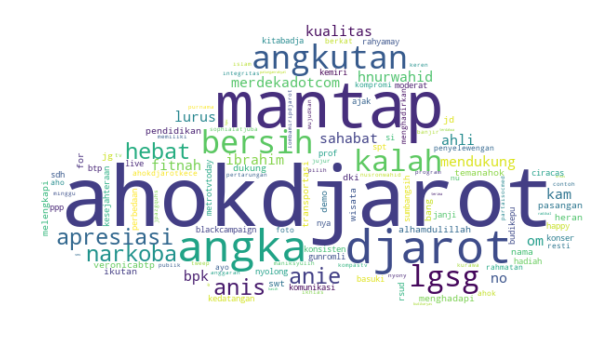

In [16]:
def transform_format(val):
    if val < 20: return 255
    else: return val

ball_mask = np.array(Image.open("cloudpic1.png").convert('L'))

transformed_ball_mask = np.ndarray((ball_mask.shape[0], ball_mask.shape[1]), np.int32)

for i in range(len(ball_mask)):
    transformed_ball_mask[i] = list(map(transform_format, ball_mask[i]))

wc = WordCloud(relative_scaling=1,normalize_plurals=False, background_color="white", max_font_size=100, mask=transformed_ball_mask, contour_width=0, contour_color='black', collocations=False).generate_from_frequencies(keywords)

print("===WordCloud from Tfidf===")
rcParams['figure.figsize'] = 10,20
plt.figure()
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

# 3.Model Training 

In [19]:
max_words = 15000
tokenize = text.Tokenizer(num_words=max_words)
tokenize.fit_on_texts(x_train) # only fit on train
x_train3 = tokenize.texts_to_matrix(x_train)
x_test3 = tokenize.texts_to_matrix(x_test)
encoder = LabelEncoder()
encoder.fit(y_train)
y_train3 = encoder.transform(y_train)
y_test3 = encoder.transform(y_test)
num_classes = np.max(y_train3) + 1

models1 = {"knn": KNeighborsClassifier(n_neighbors=1),
          "naive_bayes": GaussianNB(),
          "logit": LogisticRegression(solver="lbfgs"),
          #"svm": SVC(kernel="rbf", gamma="auto"),
          "decision_tree": DecisionTreeClassifier(),
          "random_forest": RandomForestClassifier(n_estimators=100),
          "mlp": MLPClassifier()
}

hasil=[]
n=0

print("AKURASI DARI MODEL KNN, NAIVE_BAYES, LOGIT, DECISION TREE, RANDOM_FOREST, MLP")
for i in models1:
    #print("[INFO] using '{}' model ".format(models[i]))
    model123 = models1[i]
    model123.fit(x_train3, y_train3)
    predictions = model123.predict(x_test3)
    res = accuracy_score(y_test3, predictions)*100
    hasil.append(res)
    print(i)
    print(res)

AKURASI DARI MODEL KNN, NAIVE_BAYES, LOGIT, DECISION TREE, RANDOM_FOREST, MLP
knn
56.92307692307692
naive_bayes
61.02564102564103


C:\Users\kelvin\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


logit
73.33333333333333
decision_tree
65.64102564102564
random_forest
67.6923076923077
mlp
73.33333333333333


# 4. Confusion matrix masing - masing Model

===Confusion Matrix===
-----
knn
-----
Normalized confusion matrix


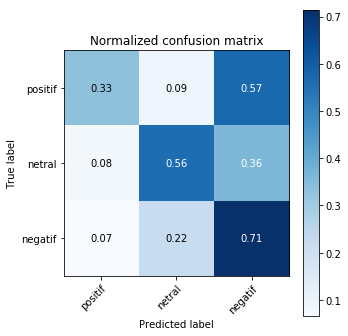

-----
naive_bayes
-----
Normalized confusion matrix


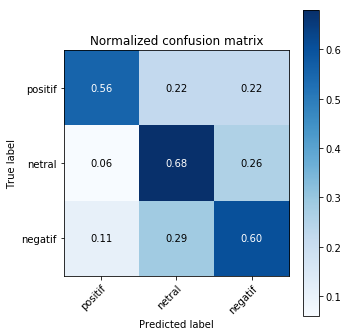

-----
logit
-----
Normalized confusion matrix


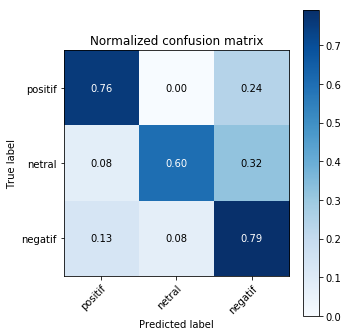

-----
decision_tree
-----
Normalized confusion matrix


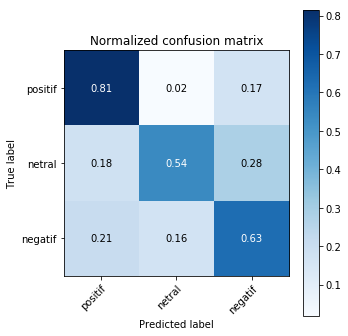

-----
random_forest
-----
Normalized confusion matrix


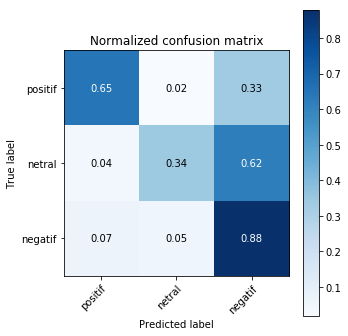

-----
mlp
-----
Normalized confusion matrix


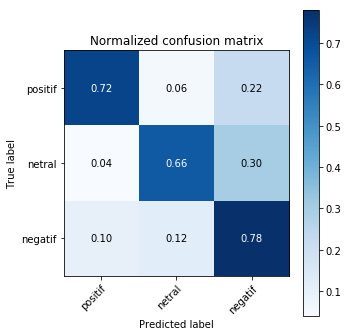

In [20]:
print("===Confusion Matrix===")
for i in models1:
    print("-----")
    print(i)
    print("-----")
    model123 = models1[i]
    label_index = model123.predict(x_test3)

    label = encoder.inverse_transform(label_index)

    plot_confusion_matrix(y_test_temp, label, classes=list(set(y_test_temp)), normalize=True,
                          title='Normalized confusion matrix')

    plt.show()